In [1]:
import sys, os, importlib
import rasterio

import pandas as pd
import geopandas as gpd
import numpy as np

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")
import GOSTRocks.rasterMisc as rMisc
from GOSTRocks.misc import tPrint

In [2]:
# Define variables
iso3 = 'KEN'

# Define global datasets
ntl_aws_base = 's3://wbgdecinternal-ntl/NTL/VIIRS/Annual/VIIRS_ANNUAL_EOG/'
ntl_files = [
    'VNL_v2_npp_201204-201303_global_vcmcfg_c202101211500.average.tif',
    'VNL_v2_npp_2013_global_vcmcfg_c202101211500.average.tif',
    'VNL_v2_npp_2014_global_vcmslcfg_c202101211500.average.tif',
    'VNL_v2_npp_2015_global_vcmslcfg_c202101211500.average.tif',
    'VNL_v2_npp_2016_global_vcmslcfg_c202101211500.average.tif',
    'VNL_v2_npp_2017_global_vcmslcfg_c202101211500.average.tif',
    'VNL_v2_npp_2018_global_vcmslcfg_c202101211500.average.tif',
    'VNL_v2_npp_2019_global_vcmslcfg_c202101211500.average.tif',
    'VNL_v2_npp_2020_global_vcmslcfg_c202101211500.average.tif'
]
admin0_layer = "/home/public/Data/GLOBAL/ADMIN/Admin0_Polys.shp"
smod_global = "/home/public/Data/GLOBAL/URBAN/GHS/GHS_SMOD/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0.tif"
urban_centres = "/home/public/Data/GLOBAL/URBAN/GHS/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg"
ghsl_global = "/home/public/Data/GLOBAL/GHSL/ghsl.vrt"
wsf_evolution = 's3://wbgdecinternal-ntl/GIS_Data/GLOBAL/WSFEvolution/WSF_Evolution.vrt'

# Define input data
in_folder = "/home/wb411133/data/Projects/KEN_Urban_Change/Data"
chart_folder = "/home/wb411133/data/Projects/KEN_Urban_Change/Charts"
maps_folder = "/home/wb411133/data/Projects/KEN_Urban_Change/Maps"
in_aoi = os.path.join(in_folder, "Nairobi_AOI.shp")

# Define data to extract
smod_local = os.path.join(in_folder, 'ghs_smod.tif')
ntl_2013   = os.path.join(in_folder, 'ntl_2014.tif')
ntl_2019   = os.path.join(in_folder, 'ntl_2019.tif')
ntl_2020   = os.path.join(in_folder, 'ntl_2020.tif')
ntl_diff   = os.path.join(in_folder, 'ntl_diff_2014_2020.tif')
ntl_diff2   = os.path.join(in_folder, 'ntl_diff_2014_2019.tif')
local_cities = os.path.join(in_folder, 'local_cities.geojson')
local_ghsl = os.path.join(in_folder, 'ghsl.tif')
local_wsf = os.path.join(in_folder, 'wsf.tif')

ntl_zonal_res = os.path.join(in_folder, "VIIRS_zonal_res.csv")
wsf_res = os.path.join(in_folder, "WSF_zonal_res.csv")

In [3]:
# Read in base data
inAOI = gpd.read_file(in_aoi)
inA = gpd.read_file(admin0_layer)
inA = inA.loc[inA['ISO3'] == iso3]

In [4]:
importlib.reload(rMisc)
# Clip data
if not os.path.exists(smod_local):
    smodR = rasterio.open(smod_global)
    rMisc.clipRaster(smodR, inA, smod_local)
    
if not os.path.exists(ntl_2019):
    ntl0 = rasterio.open(os.path.join(ntl_aws_base, ntl_files[2]))
    rMisc.clipRaster(ntl0, inA, ntl_2013)
    
    ntl1 = rasterio.open(os.path.join(ntl_aws_base, ntl_files[-1]))
    rMisc.clipRaster(ntl1, inA, ntl_2020)
    
    ntl2 = rasterio.open(os.path.join(ntl_aws_base, ntl_files[-2]))
    rMisc.clipRaster(ntl2, inA, ntl_2019)
    
if not os.path.exists(ntl_diff):
    ntl0 = rasterio.open(ntl_2013)
    ntl1 = rasterio.open(ntl_2020)
    
    ntl0_data = ntl0.read()
    ntl1_data = ntl1.read()
    
    ntl_d = ntl1_data - ntl0_data

    with rasterio.open(ntl_diff, 'w', **ntl0.meta) as outR:
        outR.write(ntl_d)
        
if not os.path.exists(ntl_diff2):
    ntl0 = rasterio.open(ntl_2013)
    ntl1 = rasterio.open(ntl_2019)
    
    ntl0_data = ntl0.read()
    ntl1_data = ntl1.read()
    
    ntl_d = ntl1_data - ntl0_data

    with rasterio.open(ntl_diff2, 'w', **ntl0.meta) as outR:
        outR.write(ntl_d)
        
if not os.path.exists(local_cities):
    inU = gpd.read_file(urban_centres)
    selU = inU.loc[inU['CTR_MN_ISO'] == iso3]
    selU.to_file(local_cities)
    
if not os.path.exists(local_ghsl):
    ghslR = rasterio.open(ghsl_global)
    selU = gpd.read_file(local_cities)
    selU = selU.loc[selU['UC_NM_MN'].isin(["Nairobi",'Ruaka','Ndenderu','Kiambu','Ruiru'])]
    rMisc.clipRaster(ghslR, selU, local_ghsl, crop=False)
    
if not os.path.exists(local_wsf):
    wsfR = rasterio.open(wsf_evolution)
    selU = gpd.read_file(local_cities)
    selU = selU.loc[selU['UC_NM_MN'].isin(["Nairobi",'Ruaka','Ndenderu','Kiambu','Ruiru'])]
    rMisc.clipRaster(wsfR, selU, local_wsf, crop=False)

In [ ]:
# Run zonal stats on nighttime lights data

selU = gpd.read_file(local_cities)
for ntl_file in ntl_files:
    year = ntl_file.split("_")[3]    
    tPrint(year)
    in_file = os.path.join(ntl_aws_base, ntl_file)
    curR = rasterio.open(in_file)
    res = rMisc.zonalStats(selU, curR, minVal=0.5)
    res = pd.DataFrame(res, columns=['SUM','MIN','MAX','MEAN'])
    selU[year] = res['SUM']

In [ ]:
selU.drop(['geometry'], axis=1).to_csv(ntl_zonal_res)

### Plot NTL change for cities

In [ ]:
cols = plotD.columns
cols[0] = '2012'
plotD.columns = cols

In [ ]:
plotD = selU.loc[selU['UC_NM_MN'].isin(["Nairobi"])]
plotD.index = plotD['UC_NM_MN']
plotD = plotD.iloc[:,-9:]
cols = plotD.columns.values
cols[0] = '2012'
plotD.columns = cols
ax = plotD.transpose().plot.line(figsize=(10,10))
ax.set_xlabel('YEAR')
ax.set_ylabel('# of pixels')
ax.legend().set_title('')
fig = ax.get_figure()
fig.savefig(os.path.join(chart_folder, "VIIRS_Nairobi.png"))

In [ ]:
plotD = selU.loc[selU['UC_NM_MN'].isin(['Ruaka','Ndenderu','Kiambu','Ruiru'])]
plotD.index = plotD['UC_NM_MN']
plotD = plotD.iloc[:,-9:]
cols = plotD.columns.values
cols[0] = '2012'
plotD.columns = cols
ax = plotD.transpose().plot.line(figsize=(10,10))
ax.set_xlabel('YEAR')
ax.set_ylabel('# of pixels')
ax.legend().set_title('')
fig = ax.get_figure()
fig.savefig(os.path.join(chart_folder, "VIIRS_OtherCities.png"))

### Summarize WSF in each urban area

In [10]:
wsfR = rasterio.open(wsf_evolution)
selU = gpd.read_file(local_cities)

if not False: #os.path.exists(wsf_res):
    res = rMisc.zonalStats(selU, wsfR, rastType='C', unqVals=list(range(1985, 2016)))
    res = pd.DataFrame(res, columns=list(range(1985, 2016)))
    #res = res.cumsum(axis=1)
    res.index = selU['UC_NM_MN']
    res.to_csv(wsf_res)
else:
    res = pd.read_csv(wsf_res, index_col=0)

In [14]:
res.head()

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
UC_NM_MN,,,,,,,,,,,,,,,,,,,,,
Busia,9145,2,51,19,13,53,31,35,24,301,...,173,144,85,111,64,79,21,24,21,7
Migori,3839,0,22,16,7,16,54,13,13,284,...,14,35,36,46,49,38,26,135,28,35
Isebania,2906,0,0,17,1,6,100,34,6,259,...,23,3,5,19,6,16,4,12,2,2
Bungoma,8939,0,106,16,6,3,11,10,7,82,...,12,54,33,24,43,18,13,14,17,5
Kimilili,2999,0,1,3,5,10,5,4,2,46,...,4,2,5,7,16,9,15,3,6,2


In [16]:
res = res.cumsum(axis=1)

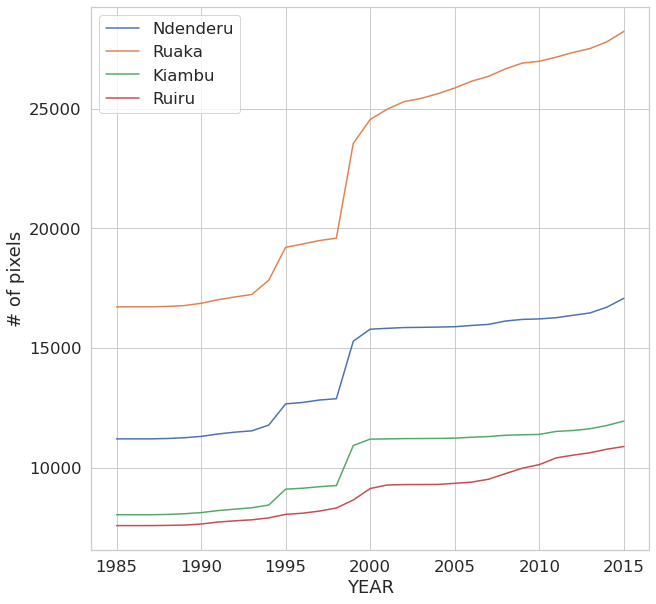

In [17]:
def plot_wsf(plotD, out_file):
    ax = plotD.transpose().plot.line(figsize=(10,10))
    ax.set_xlabel('YEAR')
    ax.set_ylabel('# of pixels')
    ax.legend().set_title('')
    fig = ax.get_figure()
    fig.savefig(out_file)

plotD = res.loc[res.index.isin(['Ruaka','Ndenderu','Kiambu','Ruiru'])]
plot_wsf(plotD, os.path.join(chart_folder, "WSF_other_cities.png"))

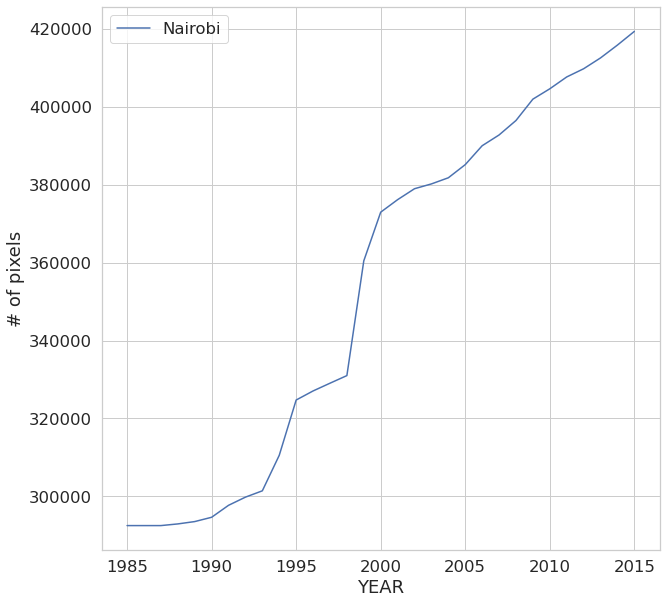

In [18]:
plotD = res.loc[res.index.isin(['Nairobi'])]
plot_wsf(plotD, os.path.join(chart_folder, "WSF_Nairobi.png"))

### Intersect the landuse data and WSF evolution

In [ ]:
landuse_file = "/home/wb411133/data/Projects/KEN_Urban_Change/Data/ML_Results/prediction_result.shp"
inL = gpd.read_file(landuse_file)
inL['geometry'] = inL['geometry'].apply(lambda x: x.centroid)
if not os.path.exists(out_file):
    # Rasterize landuse
    out_file = os.path.join(in_folder, "landuse.tif")
    rMisc.rasterizeDataFrame(inL, out_file, idField='predict', templateRaster=local_wsf)

In [ ]:
landR = rasterio.open(out_file)
wsfR = rasterio.open(local_wsf)

landD = landR.read()
wsfD = wsfR.read()

In [ ]:
summary = {}
for wsf_val in range(1985, 2016):
    cur_wsf = wsfD <= wsf_val
    cur_land = cur_wsf * landD    
    summary[wsf_val] = np.unique(cur_land, return_counts=True)

In [ ]:
summary

In [ ]:
landuse_evolution = pd.DataFrame(summary).transpose()
landuse_evolution.columns = ['FUBAR', 'res']
landuse_evolution.drop(['FUBAR'], axis=1, inplace=True)
out_cols = ['NA','Commercial','Industrial','Institutional','Residential','Res - Dense','Res - Informal']
landuse_evolution = pd.DataFrame(landuse_evolution['res'].to_list(), columns = out_cols)
landuse_evolution.drop(['NA'], axis=1, inplace=True)
landuse_evolution.index = list(range(1985, 2016))

In [ ]:
plot_wsf(landuse_evolution.transpose(), os.path.join(chart_folder, "Landuse_evolution.png"))